# 손글씨(숫자) 분류 경진대회

`-` 참고 : https://dacon.io/competitions/official/235838/codeshare/3717?page=2&dtype=recent

`-` 참고 : https://dacon.io/competitions/official/235838/codeshare/3758?page=2&dtype=recent
    
`-` 참고 : https://tutorials.pytorch.kr/beginner/basics/intro.html

## 데이터 불러오기

In [3]:
import pandas as pd
import warnings
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings(action = 'ignore')

In [6]:
train = pd.read_csv('C:/Users/Jaesu/mnist_dataset/train/train_data.csv')

In [7]:
train.head()

,file_name,label
0,train0001.png,8
1,train0002.png,8
2,train0003.png,8
3,train0004.png,8
4,train0005.png,8


`-` 이미지파일 이름과 라벨이 있다

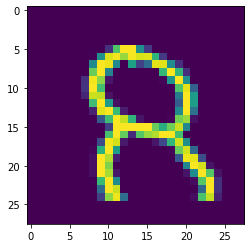

In [8]:
file_dir = 'C:/Users/Jaesu/mnist_dataset/train/'
sample_file = train['file_name'][0] ## 0번째 인덱스 파일 이름 선택

sample_image_array= np.array(Image.open(file_dir + sample_file)) ## path에서 이미지를 불러온 뒤 numpy array로 변환

## 이미지 출력
plt.imshow(np.array(sample_image_array))
plt.show()

In [9]:
print('sample image의 모양:' , sample_image_array.shape)

sample image의 모양: (28, 28)


`-` $28\times 28$크기의 array이다(모양은 8)

## 딥러닝을 이용한 학습

`-` pytorch를 사용하여 학습해보자

`-` 일단은 2차원 데이터를 1차원으로 만들어서 학습시키자

### Dataset, DataLoader 준비

`-` `Dataset` : 학습에 필요한 데이터셋을 정의(샘플과 정답(label)을 저장)

`-` `DataLoader` : 모델에 데이터셋을 어떤 방식으로 전달할지를 (데이터셋을 섞을지 말지, 한번에 몇개씩(batch_size) 모델에게 던져줄지 등) 정의하며

`-` Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms

`-` 파이토치에서 커스텀 데이터셋을 만들 땐 `Dataset` 클래스를 상속받아서 만든다

`-` 또한 `__init__` , `__len__` ,  `__getitem__` 함수는 필수로 구현해야 한다

In [11]:
class MNIST(Dataset):  ## 파이토치의 Dataset 클래스를 상속받음   
    def __init__(self, file_path_list, labels = None): 
        self.file_path_list = file_path_list ## 이미지 파일 경로 리스트
        self.labels = labels ## 이미지의 라벨
        self.PIL2tensor = transforms.PILToTensor() ## 이미지 파일을 텐서로 만들고 정규화한다(0~1)
        
    def __getitem__(self, idx):  ## [] 연산자 오버로딩     
        image = Image.open(self.file_path_list[idx])  ## 해당 인덱스에 맞는 image 추출
        tensor_image = self.PIL2tensor(image)  ## PIL로 읽은 이미지를 torch tensor형으로 변환
        flattened_image = tensor_image.flatten().float() ## 2차원 이미지를 1차원으로 변환
        
        if self.labels is not None: ## 라벨이 존재 하는경우: 학습(train)에 이용할경우
            label = self.labels[idx] ## 해당 인덱스에 맞는 라벨 추출
            return flattened_image, label  ## 1차원으로 변환한 이미지와 라벨을 return
        
        return flattened_image ## test단계에선 label이 존재하지 않기때문에 image만을 return
        
    def __len__(self): 
        return len(self.file_path_list)  ## 이미지 파일 경로 리스트의 길이 = 총 이미지파일의 개수 

In [12]:
file_path_list = file_dir + train['file_name'] ## 브로드캐스트 ## 이미지 파일의 경로
labels = train['label'] ## 이미지의 라벨

mnist_dataset = MNIST(file_path_list, labels) ## train 데이터이므로 label이 존재하니 인자로 넣어준다

In [13]:
mnist_loader = DataLoader(mnist_dataset, batch_size = 32, shuffle = True) ## 학습마다 32개씩 데이터를 가지고 학습 ## ex) 데이터가 100개라면 32, 32, 32, 4

### 모델 설계

`-` $784\,(=28\times 28)$개의 픽셀값을 $100$개의 은닉층으로 사영(projection)시키고 또 $10$개의 확률값으로 뽑아내는 작업을 수행

`-` 커스텀 신경망은 파이토치의 `Module` 클래스를 상속받아서 만든다

`-` 또한 `forward` 함수는 필수로 구현해야 한다 $\longrightarrow$ 다음 layer로 전달할 값을 리턴

`-` `__init__` 함수를 통해 계층(layer)들을 초기화한다

In [44]:
## accuracy 계산
def compute_acc(true, pred):
    return sum(true == pred) / len(true)

In [15]:
class FullyConnected(nn.Module):
    def __init__(self, input_dim, class_num):  ## 입력차원과 출력차원을 인자로 받는다
        super(FullyConnected, self).__init__() 
        self.pix2hidden = nn.Linear(input_dim, 100)  ## 784개의 픽셀값을 100개의 은닉층으로 사영시키는 layer
        self.hidden2dight = nn.Linear(100, class_num)  ## 100개의 은닉층을 10개 클래스의 확률값으로 사영시키는 layer
        self.softmax = nn.Softmax()  ## 10개의 logit을 확률값으로 변환 (각 숫자일 확률)
        
    def forward(self, x):
        hidden = self.pix2hidden(x)  ## 784개의 픽셀값을 100개의 은닉층으로 사영
        digit_logit = self.hidden2dight(hidden)  ## 100개의 은닉층을 10개 클래스의 확률값으로 사영
        digit_proba = self.softmax(digit_logit)  ## 10개 클래스의 logit을 확률값으로 변환
        return digit_proba  ## 확률값 return

In [16]:
from tqdm import tqdm ## 출력 현황을 나타내는 라이브러리

model = FullyConnected(784, 10) ## 모델 선언 
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' ## 학습에 사용할 device 선언 gpu가 사용 가능하다면 gpu 아니라면 cpu로 학습
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5) ## optimizer 선언 (Adam)
ce_loss = nn.CrossEntropyLoss() ## loss함수 선언 cross entrophy loss

model.to(device)
for Epoch in tqdm(range(30)):
    for batch, labels in mnist_loader:
        batch = batch.to(device)
        labels = labels.to(device)
        
        output = model(batch) ## 모델에 이미지들을 넣은 뒤 값 출력
        loss = ce_loss(output, labels) ## loss 계산
        loss.backward() ## 오차를 역전파
        optimizer.step() ## 업데이트
        optimizer.zero_grad() ## 다음 업데이트를 위한 미분값 초기화
        acc = compute_acc(labels.detach().cpu().numpy(), output.detach().cpu().numpy().argmax(-1))
        
    if Epoch % 10 == 0 or Epoch == 29:
        print(f'EPOCH: {Epoch}, loss: {loss}, acc: {acc}')

  3%|██▊                                                                                | 1/30 [00:40<19:35, 40.52s/it]

EPOCH: 0, loss: 2.078181743621826, acc: 0.375


 37%|██████████████████████████████                                                    | 11/30 [01:18<01:25,  4.51s/it]

EPOCH: 10, loss: 2.2523984909057617, acc: 0.25


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [01:56<00:34,  3.84s/it]

EPOCH: 20, loss: 1.8361501693725586, acc: 0.625


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [02:27<00:00,  4.91s/it]

EPOCH: 29, loss: 2.0866358280181885, acc: 0.375


### test 예측

`-` test 데이터에는 label이 존재하지 않기때문에 image 경로들만 넣어준다

In [49]:
test = pd.read_csv('C:/Users/Jaesu/mnist_dataset/test/test_data.csv') ## test_data.csv 불러오기
test_file_dir = 'C:/Users/Jaesu/mnist_dataset/test/'

`-` dataset을 만든 뒤 DataLoader를 선언한다

`-` 이때 shuffle옵션을 True로 넣으면 절대 안된다

`-` 파일이 순서대로 들어가지 않기때문에 파일 이름과 예측한 라벨이 어긋날 수 있음

In [18]:
test_mnist_dataset = MNIST(test_file_dir + test['file_name'])
test_mnist_loader = DataLoader(test_mnist_dataset, batch_size = 32)

preds = None

for test_batch in tqdm(test_mnist_loader):
    test_batch = test_batch.to(device)
    output = model(test_batch)
    
    digit_pred = output.detach().cpu().numpy().argmax(-1)
    if preds is None:
        preds = digit_pred
    else:
        preds = np.concatenate([preds, digit_pred]) 

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:34<00:00,  4.59it/s]


In [19]:
submission = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/손글씨(숫자)-분류/Data/sample_submission.csv') ## sample submission 불러오기

submission['label'] = preds

submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/손글씨(숫자)-분류/Data/submission.csv', index = False)

## 딥러닝을 이용한 학습 2

### Data augmentation

`-` 데이터를 회전시키고 찌그러트리고 반전시키고 자르고 옆으로 밀어서 지금의 이미지와 비슷하지만 다른 데이터를 만들자

`-` torchvision의 `trasform` 클래스를 사용

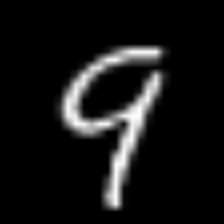

In [20]:
resize = transforms.Resize(224) ## 224 * 224 사이즈로 변환
crop = transforms.CenterCrop(112) ## center를 중심으로 112만 잘라냄
rotation = transforms.RandomRotation(40) ## 시계 혹은 반시계로 40도만큼 돌림
erasing = transforms.Compose([
    transforms.PILToTensor(),
    transforms.RandomErasing(1),
    transforms.ToPILImage()
])  ## 무작위로 특정 영역 지우기
vertical_flip = transforms.RandomVerticalFlip(1) ## 상하반전
horizontal_file = transforms.RandomHorizontalFlip(1) ## 좌우반전

sample_image = Image.open(file_path_list[10]) ## transform을 실험할 sample image
sample_image = resize(sample_image)
sample_image

`-` 위에 보이는 9는 이미지 변환 실험에 쓸 sample이다

`-` $28 \times 28$이 너무 작으니 $224 \times 224$로 실험하자

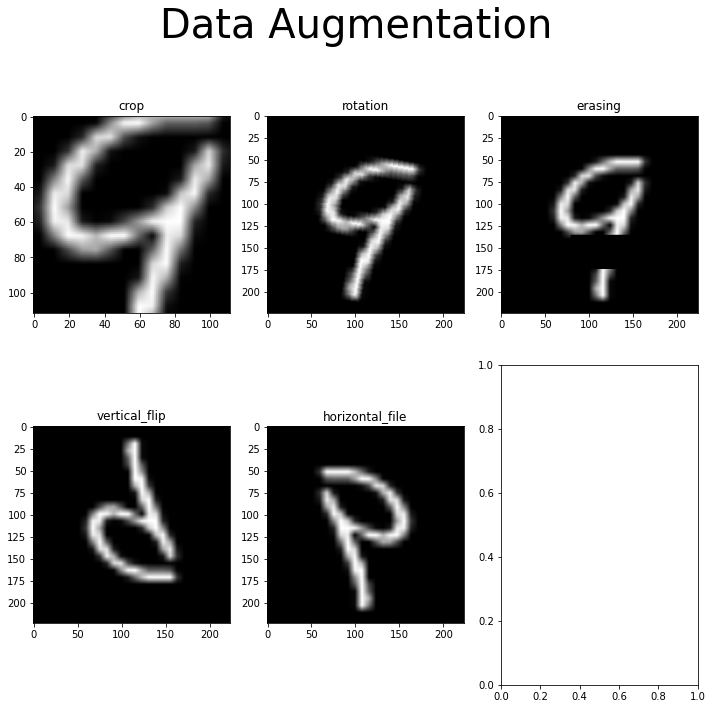

In [21]:
transform_list = [crop, rotation, erasing, vertical_flip, horizontal_file]
transform_name = ['crop', 'rotation', 'erasing', 'vertical_flip', 'horizontal_file']

fig, ax = plt.subplots(2, 3, figsize = (10, 10))
fig.suptitle('Data Augmentation', fontsize = 40)
for i, transform_idx in enumerate(range(0, 4, 3)):
    for j in range(3):
        if transform_idx + j >= 5:
            break
        ax[i, j].imshow(transform_list[transform_idx + j](sample_image), cmap = 'gray')
        ax[i, j].set_title(transform_name[transform_idx + j])

fig.tight_layout()

`-` 이런 방식으로 이미지 데이터를 늘리거나 변주를 주는 방법은 컴퓨터비전 문제를 해결할 때 성능 상승에 큰 이점을 가져다준다

`-` 다만 9의 경우 상하반전을 실행한다면 6과 구분하기 힘들며

`-` 무작위로 지우는 방식도 너무 많은 부분을 제거하면 원본이 크게 훼손되기에 적당한 scale을 설정해야 한다

`-` 따라서 augmentaion을 진행할 때에는 사전에 라벨링이 어떻게 되어있는지

`-` 자칫 학습에 혼선을 줄 수 있는 데이터를 만들어낼 가능성이 있는지 미리 체크해야 된다

### Dataset, DataLoader 준비

In [46]:
class MNIST2(Dataset):    
    def __init__(self, file_path_list, labels = None): 
        self.file_path_list = file_path_list
        self.labels = labels
        self.random_choice = transforms.RandomChoice([transforms.RandomRotation(degrees = 40), ## 시계방향으로 40도 회전
                                                      transforms.RandomResizedCrop(size = 28),
                                                      transforms.RandomHorizontalFlip(p = 0.5)])
        self.transform = transforms.Compose([
          # transforms.Resize(224), ## 시각화를 위해 사이즈를 키웠던 것
            self.random_choice,
            transforms.PILToTensor(),
        ])
        
    def __getitem__(self, idx):       
        image = Image.open(self.file_path_list[idx]) ## 해당 인덱스에 맞는 image 추출
        tensor_image = self.transform(image).float() ## PIL로 읽은 이미지를 torch tensor형으로 변환
        ## 지금은 2차원 이미지 처리중이므로 flatten() 사용 안함
        
        if self.labels is not None: ## 라벨이 존재 하는경우: 학습에 이용할경우
            label = self.labels[idx] ## 해당 인덱스에 맞는 라벨 추출
            return tensor_image, label  ## Agumentation을 적용한 2D 이미지와 라벨을 return
        
        return tensor_image ## test단계에선 label이 존재하지 않기때문에 image만을 return
        
        
    def __len__(self):
        return len(self.file_path_list)

In [41]:
labels = train['label']
mnist_dataset = MNIST2(file_path_list, labels)
mnist_loader = DataLoader(mnist_dataset, batch_size = 32, shuffle = True)

### CNN 모델 설계

`-` 2차원 행렬 형태를 유지하며 이미지에서 정보를 추출할 수 있는 구조

In [42]:
class BasicConv(nn.Module):
    def __init__(self, image_width, image_height): ## 학습에 사용할 레이어 정의
        super(BasicConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size = (3, 3), padding = 1) 
        self.conv2 = nn.Conv2d(64, 128, kernel_size = (3, 3) , padding = 1)
        self.maxpool = nn.MaxPool2d(2) ## 커널사이즈 (2,2)
        self.batchnorm = nn.BatchNorm2d(128) ## input차원 128
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear((image_width // 2) * (image_height // 2) * 128, 10)
        
    def forward(self, x):
        ## 2D part
        x = self.conv1(x)     ## 컨볼루션
        x = self.conv2(x)     ## 컨볼루션
        x = self.batchnorm(x) ## 배치노멀라이즈
        x = self.maxpool(x)   ## 맥스풀링
        x = self.relu(x)      ## 렐루

        ## 1D part
        x = self.flatten(x) ## 평활화
        x = self.linear(x)  ## 선형변환
        return x

In [47]:
model = BasicConv(28, 28) ## 클래스 인스턴스 생성

### 모델학습

In [45]:
device = 'cuda:3' if torch.cuda.is_available() else 'cpu' ## 학습에 사용할 device 선언 gpu가 사용 가능하다면 gpu 아니라면 cpu로 학습
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5) ## optimizer 선언 (Adam)
ce_loss = nn.CrossEntropyLoss() ## loss함수 선언 cross entrophy loss

model.to(device)

for Epoch in tqdm(range(10)):
    for batch, labels in mnist_loader:
        batch = batch.to(device)
        labels = labels.to(device)
        
        output = model(batch) # 모델에 이미지들을 넣은 뒤 값 출력
        loss = ce_loss(output, labels) # loss 계산
        optimizer.zero_grad()
        loss.backward() # 오차를 역전파
        optimizer.step()
        acc = compute_acc(labels.detach().cpu().numpy(), output.detach().cpu().numpy().argmax(-1))
        
    
    print(f'EPOCH: {Epoch + 1}, loss: {loss}, acc: {acc}')

 10%|████████▎                                                                          | 1/10 [00:29<04:29, 29.98s/it]

EPOCH: 1, loss: 1.4826728105545044, acc: 0.625


 20%|████████████████▌                                                                  | 2/10 [00:58<03:54, 29.34s/it]

EPOCH: 2, loss: 1.058363676071167, acc: 0.5


 30%|████████████████████████▉                                                          | 3/10 [01:28<03:27, 29.63s/it]

EPOCH: 3, loss: 1.466658353805542, acc: 0.75


 40%|█████████████████████████████████▏                                                 | 4/10 [01:58<02:58, 29.67s/it]

EPOCH: 4, loss: 1.8206191062927246, acc: 0.375


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:27<02:27, 29.55s/it]

EPOCH: 5, loss: 1.5745270252227783, acc: 0.5


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:56<01:57, 29.32s/it]

EPOCH: 6, loss: 1.3129894733428955, acc: 0.625


 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:26<01:27, 29.29s/it]

EPOCH: 7, loss: 0.929649829864502, acc: 0.75


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:55<00:58, 29.45s/it]

EPOCH: 8, loss: 1.2511965036392212, acc: 0.5


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [04:25<00:29, 29.46s/it]

EPOCH: 9, loss: 1.329139232635498, acc: 0.375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:56<00:00, 29.67s/it]

EPOCH: 10, loss: 1.3494322299957275, acc: 0.625


### test 예측

In [50]:
test_mnist_dataset = MNIST2(test_file_dir + test['file_name'])
test_mnist_loader = DataLoader(test_mnist_dataset, batch_size = 32)

preds = None

for test_batch in tqdm(test_mnist_loader):
    test_batch = test_batch.to(device)
    output = model(test_batch)
    
    digit_pred = output.detach().cpu().numpy().argmax(-1)
    if preds is None:
        preds = digit_pred
    else:
        preds = np.concatenate([preds, digit_pred])

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.77it/s]


In [51]:
submission['label'] = preds

submission.to_csv('submission2.csv', index = False)

`-` 간단한 CNN 설계 끝